<a href="https://colab.research.google.com/github/DenisPotekhin2002/Generative-Models-2025/blob/main/Assignment%203/3_tricks_metrics_prev_HW_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

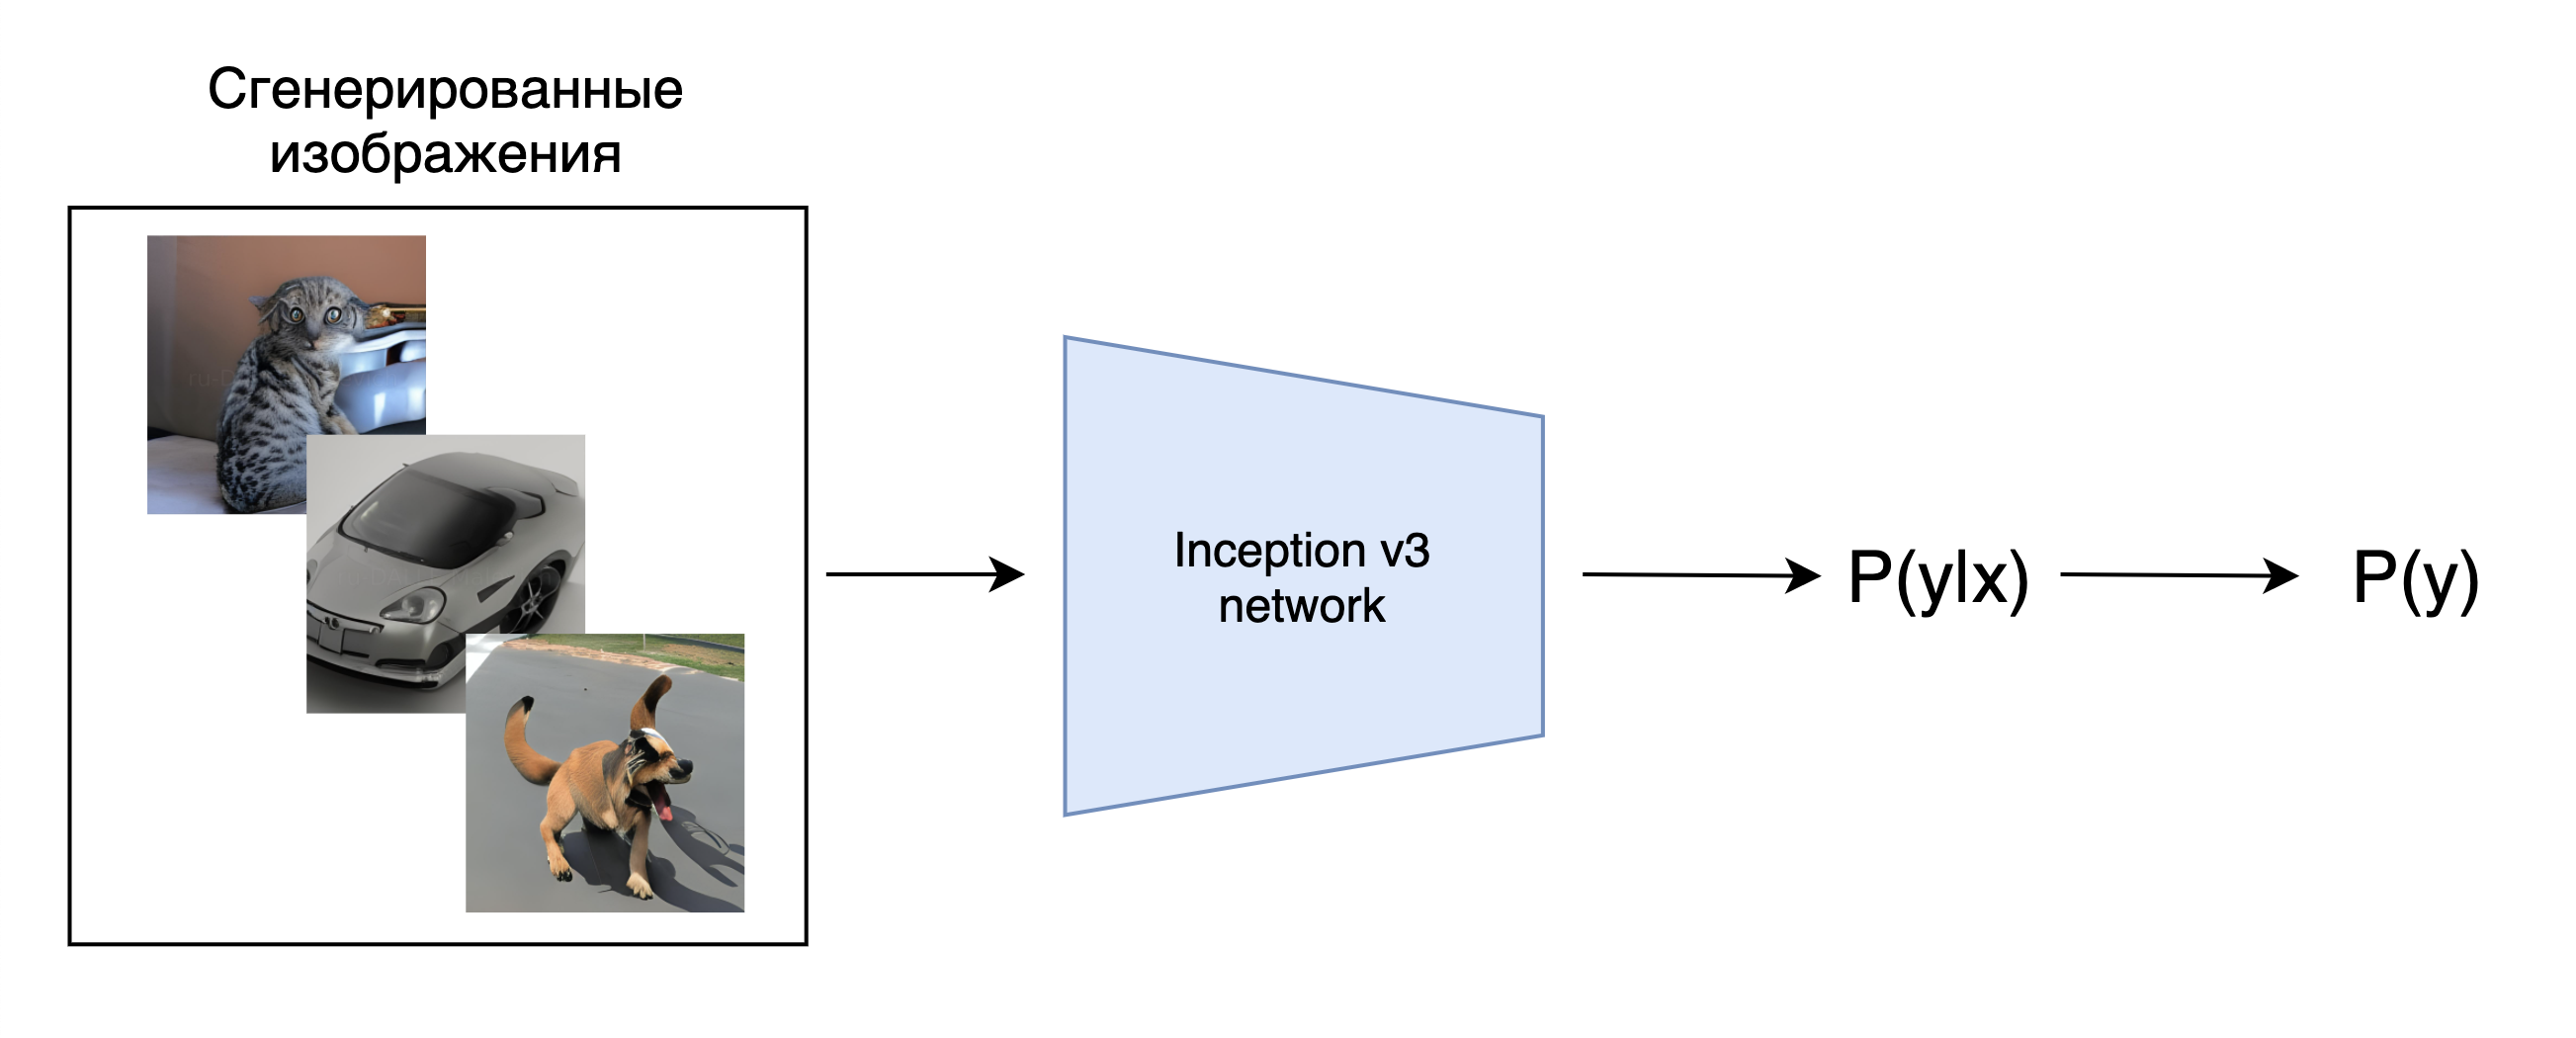

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

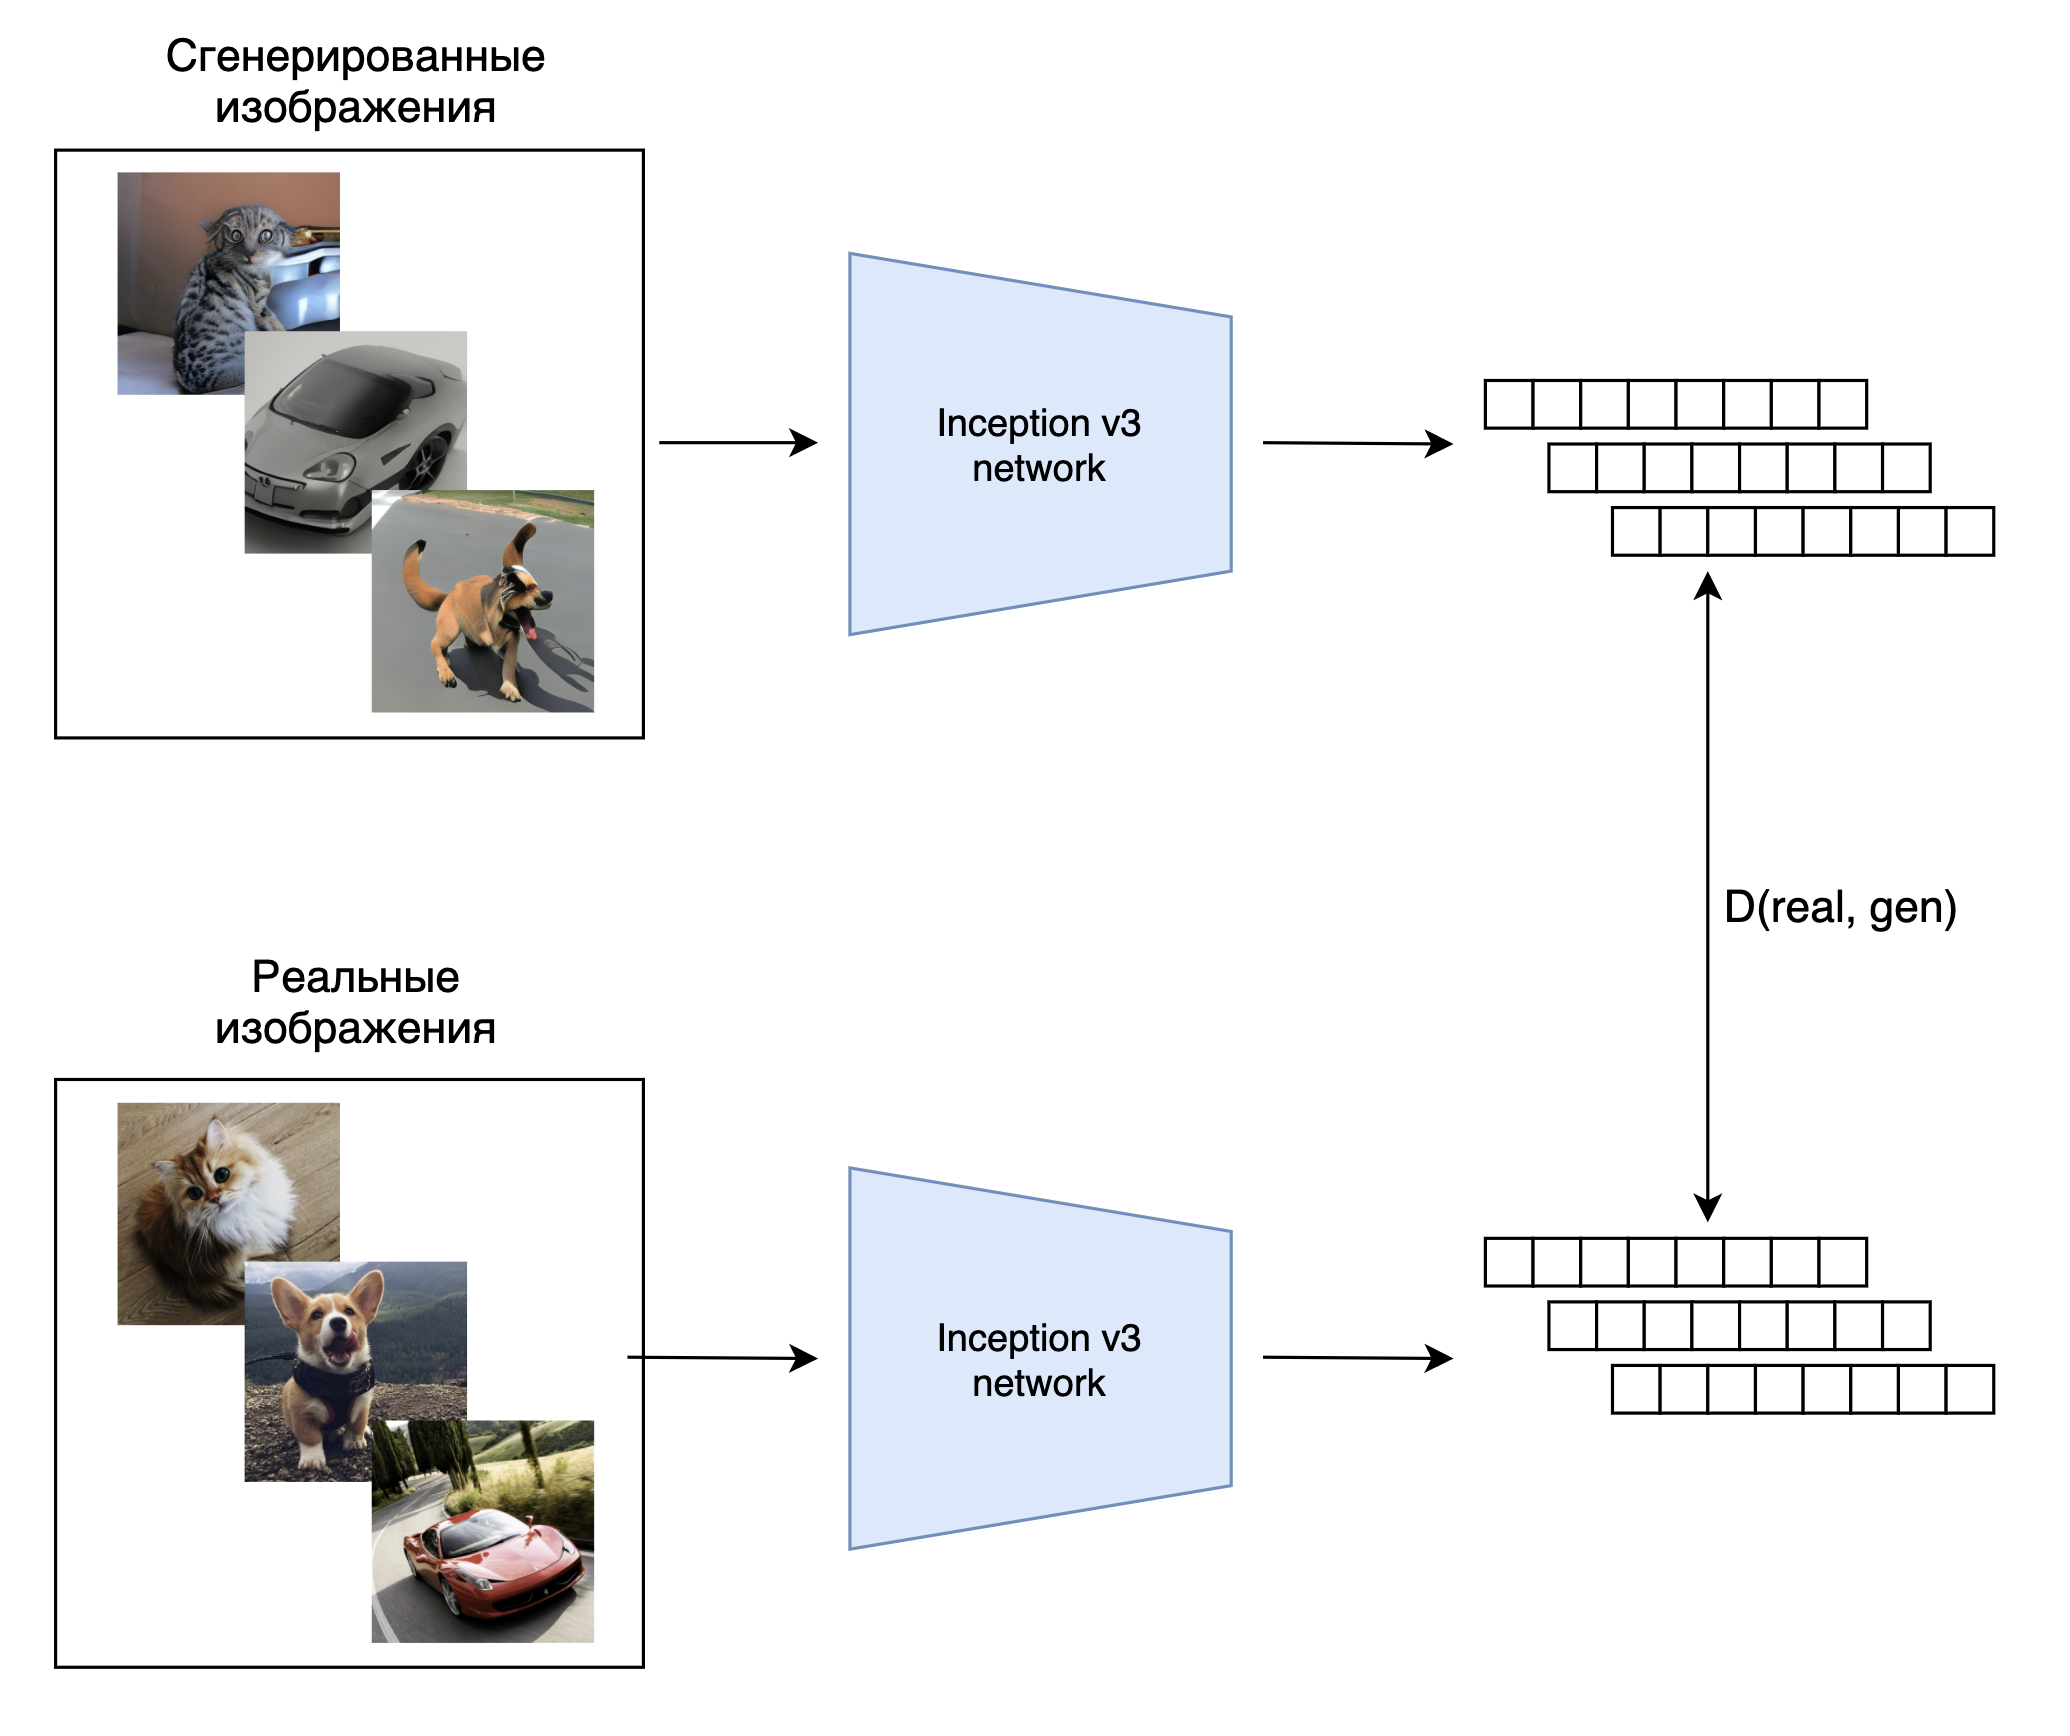

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN и диффузию (DDPM) на датасете CIFAR10. Для GAN вы можете использовать методы регуляризации, чтобы улучшить его качество, например label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных (вспомогательный код для трюков в ганах приведен в ноутбуке). Переиспользуйте код из 1 и 2 домашней работы.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей. Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
GAN | |
Diffusion | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [49]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 20
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091506, -0.72967321, -0.59843135, -0.46718955,
        -0.33594775, -0.20470589, -0.07346404,  0.05777776,  0.18901956,
         0.32026136,  0.45150328,  0.58274508,  0.71398687,  0.84522879,
         0.97647059]),
 <BarContainer object of 15 artists>)

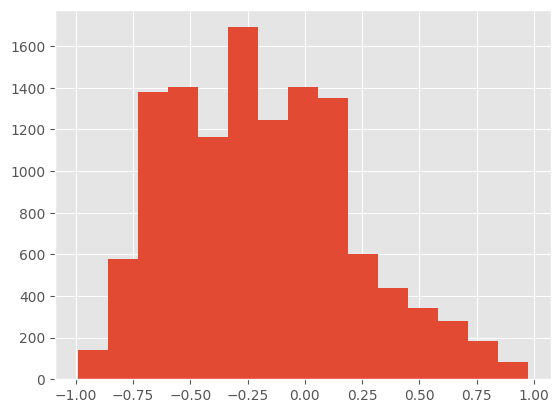

In [50]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

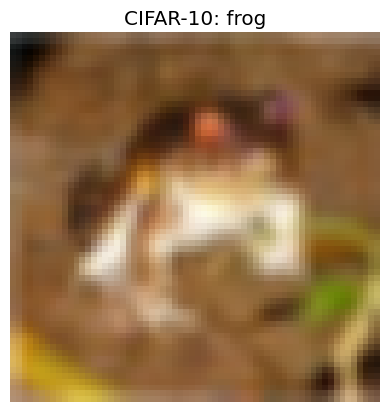

In [51]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    out = (img + 1) / 2
    return out.clamp(0, 1)

# show image sample with matplotlib
def show_image(img_tensor, denormalize=True, title=None):
    if denormalize:
        img_tensor = denorm(img_tensor)

    img_np = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img_np)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_image(img, title=f"CIFAR-10: {cifar_dataset.classes[label]}")

In [52]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    pin_memory=True if CFG.device == "cuda" else False
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Спектральная нормализация

In [53]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [54]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator with dropout
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [55]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [56]:
# show the output of model
y = G(torch.randn(2, CFG.nz, 1, 1).to(CFG.device))

In [57]:
# feel free to reuse your training functions
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
CFG.beta1 = 0.5
optimizerG = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))

Discriminator Training

In [58]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator
def add_noise_to_labels(labels, noise_level=0.1):
    noise = torch.randn_like(labels) * noise_level
    return torch.clamp(labels + noise, 0, 1)

In [60]:
def reset_grad():
    optimizerD.zero_grad()
    optimizerG.zero_grad()

# Define a variable for label smoothing
LABEL_SMOOTH = 0.8  # Reduced from 0.9 to make labels less extreme

def add_noise_to_labels(labels, noise_level=0.2):  # Increased noise level
    """Add noise to labels for label smoothing"""
    noise = torch.randn_like(labels) * noise_level
    return torch.clamp(labels + noise, 0.1, 0.9)  # Keep within reasonable bounds

def train_discriminator(images):
    batch_size = images.size(0)

    # Create the labels which are later used as input for the BCE loss
    # Use more aggressive label smoothing
    real_labels = torch.ones(batch_size, device=CFG.device) * LABEL_SMOOTH
    fake_labels = torch.zeros(batch_size, device=CFG.device) * (1 - LABEL_SMOOTH)

    # Add more noise to labels
    real_labels = add_noise_to_labels(real_labels, noise_level=0.15)
    fake_labels = add_noise_to_labels(fake_labels, noise_level=0.15)

    # Add noise to real images before feeding to discriminator
    images_noisy = images + torch.randn_like(images) * 0.05  # Add 5% noise

    outputs = D(images_noisy)
    # Loss for real images
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, CFG.nz, 1, 1, device=CFG.device)
    fake_images = G(z)

    # Add noise to fake images too
    fake_images_noisy = fake_images + torch.randn_like(fake_images) * 0.05

    outputs = D(fake_images_noisy.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Clip gradients to prevent explosion
    torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)

    # Adjust the parameters using backprop
    optimizerD.step()

    return d_loss, real_score, fake_score

Generator Training

In [61]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [62]:
def train_generator():
    # Generate fake images and calculate loss
    batch_size = CFG.batch_size

    # Add Gaussian noise to latent vectors with variable noise
    z = np.random.normal(0, 1, (batch_size, CFG.nz))
    noise_level = 0.01 * np.random.uniform() * np.max(np.abs(z))  # Reduced noise
    z = z.astype('float32') + noise_level * np.random.normal(size=z.shape)
    z = torch.tensor(z, dtype=torch.float32, device=CFG.device).view(batch_size, CFG.nz, 1, 1)

    fake_images = G(z)
    labels = torch.ones(batch_size, device=CFG.device) * LABEL_SMOOTH  # Use same label smoothing

    # Add noise to labels
    labels = add_noise_to_labels(labels, noise_level=0.1)

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()

    # Clip gradients for generator too
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)

    optimizerG.step()

    return g_loss, fake_images

## Start the training process

In [63]:
def save_fake_images(index):
    batch_size = 100
    z = np.random.normal(0, 1, (batch_size, CFG.nz))
    noise = 0.005 * np.random.uniform() * np.max(np.abs(z))
    z = z.astype('float32') + noise * np.random.normal(size=z.shape)
    z = torch.tensor(z, dtype=torch.float32, device=CFG.device).view(batch_size, CFG.nz, 1, 1)

    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = f'fake_images_cifar_improved-{index:04d}.png'
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [64]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, _ = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/20], Step [200/391], d_loss: 1.4279, g_loss: 1.2748, D(x): 0.51, D(G(z)): 0.45
Saving fake_images_cifar_improved-0001.png
Epoch [1/20], Step [200/391], d_loss: 1.2441, g_loss: 1.1301, D(x): 0.48, D(G(z)): 0.26
Saving fake_images_cifar_improved-0002.png
Epoch [2/20], Step [200/391], d_loss: 1.2116, g_loss: 1.1216, D(x): 0.60, D(G(z)): 0.34
Saving fake_images_cifar_improved-0003.png
Epoch [3/20], Step [200/391], d_loss: 1.0685, g_loss: 1.2594, D(x): 0.62, D(G(z)): 0.25
Saving fake_images_cifar_improved-0004.png
Epoch [4/20], Step [200/391], d_loss: 1.3663, g_loss: 1.1429, D(x): 0.61, D(G(z)): 0.49
Saving fake_images_cifar_improved-0005.png
Epoch [5/20], Step [200/391], d_loss: 1.2180, g_loss: 1.0426, D(x): 0.49, D(G(z)): 0.28
Saving fake_images_cifar_improved-0006.png
Epoch [6/20], Step [200/391], d_loss: 1.1963, g_loss: 0.9168, D(x): 0.50, D(G(z)): 0.28
Saving fake_images_cifar_improved-0007.png
Epoch [7/20], Step [200/391], d_loss: 1.1678, g_loss: 0.7261, D(x): 0.53, D(G(z)): 

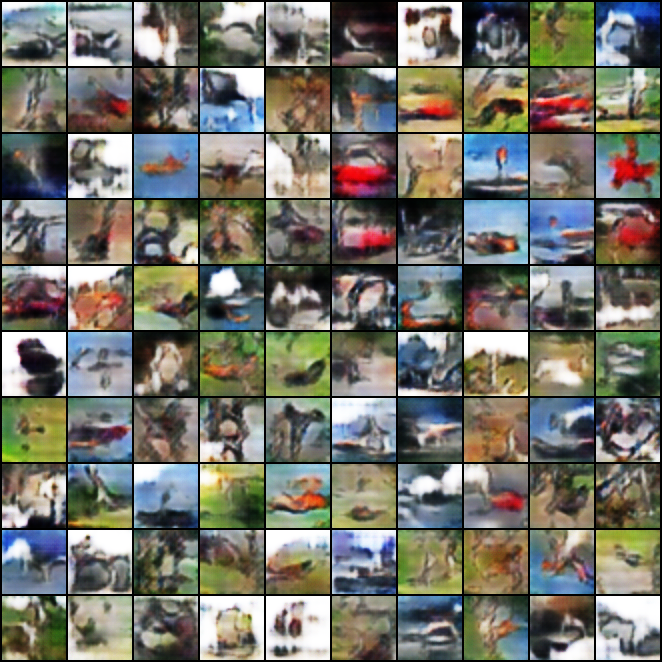

In [69]:
Image(os.path.join(CFG.sample_dir, 'fake_images_cifar_improved-0018.png'))

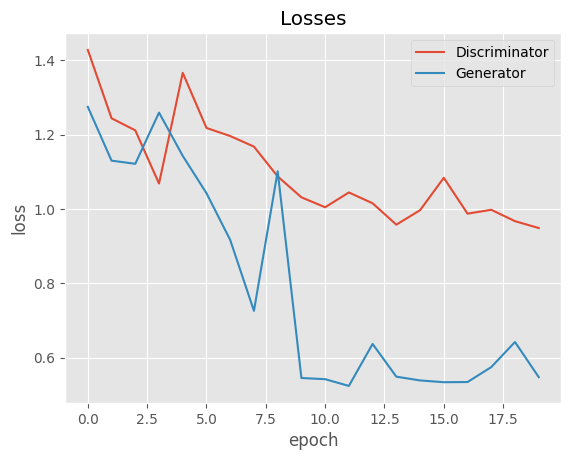

In [70]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

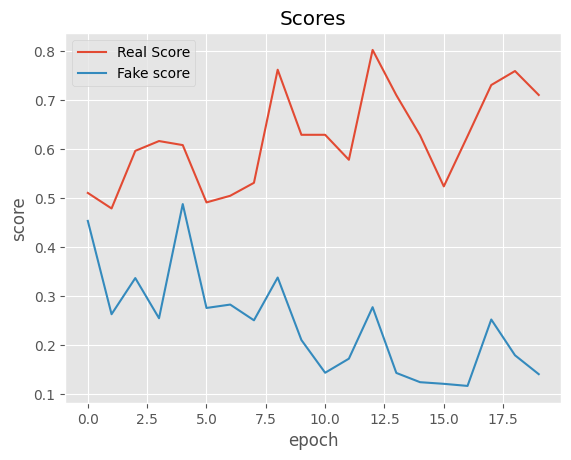

In [71]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [3]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 342 (delta 55), reused 96 (delta 46), pack-reused 230 (from 1)
Receiving objects: 100% (342/342), 93.34 KiB | 9.33 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [73]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID


/content/pytorch-gan-metrics


In [75]:
!pip install -e .

Obtaining file:///content/pytorch-gan-metrics
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch_image_generation_metrics
    Found existing installation: pytorch-image-generation-metrics 0.6.1
    Uninstalling pytorch-image-generation-metrics-0.6.1:
      Successfully uninstalled pytorch-image-generation-metrics-0.6.1
  Running setup.py develop for pytorch_image_generation_metrics


In [4]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import subprocess
from pytorch_image_generation_metrics import get_inception_score_and_fid

# Create FID reference .npz file if it doesn't exist
real_dir = './cifar10_real_images'
stats_path = './cifar10_fid_ref.npz'

if not os.path.exists(stats_path):
    os.makedirs(real_dir, exist_ok=True)

    # Save real CIFAR-10 images normalized to [0, 1]
    for i in range(50000):
        img, _ = cifar_dataset[i]
        img = (img + 1) / 2.0  # Denormalize from [-1, 1] to [0, 1]
        save_image(img, os.path.join(real_dir, f'{i:05d}.png'))

    # Create .npz file using the correct module from documentation
    subprocess.run([
        'python', '-m', 'pytorch_image_generation_metrics.fid_ref',
        '--path', real_dir,
        '--output', stats_path
    ], capture_output=True)

# Generator Dataset
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim, num_samples=500):
        self.G = G
        self.z_dim = z_dim
        self.num_samples = num_samples
        self.G.eval()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        with torch.no_grad():
            z = torch.randn(1, self.z_dim, 1, 1).cuda()
            img = self.G(z)
            if isinstance(img, (tuple, list)):
                img = img[0]
            img = (img + 1) / 2.0  # Normalize to [0, 1]
            img = torch.clamp(img, 0, 1)
            return img.squeeze(0)

# Create DataLoader
dataset = GeneratorDataset(G, CFG.nz, num_samples=500)
loader = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=0)

# Calculate IS and FID
(IS, IS_std), FID = get_inception_score_and_fid(loader, stats_path, device='cuda')
print(f"Inception Score: {IS:.4f} ± {IS_std:.4f}")
print(f"FID: {FID:.4f}")

ModuleNotFoundError: No module named 'pytorch_gan_metrics'